# Non-Stationarity

This notebook is designed to be read along with [the third article](https://medium.com/@alejandro.aristizabal24/understanding-reinforcement-learning-hands-on-part-3-non-stationarity-544ed094b55) on a series on Reinforcement Learning. It is adviced to go through both resources at the same time, to cover both thery and code on the topic. The notebook will be focused on applying the theory, while the article is focuesd on explaining it.

## Preliminaries

In [1]:
# Import necessary libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import gym
from tqdm import tqdm
import time

## Scenario

The scenario for this section is based on the multi-armed environment presented on the previous section. Here, we're going to implement a way in which the underlying mechanics of the environment are non-static. Particularly, we're interested in changing the expected value for each action after every interaction. This change is small and smooth, so our agent can still consider previous experience meaningful for future decision-making.

In [2]:
from gym import spaces
from gym.utils import seeding

class NonStationaryArmedBanditsEnv(gym.Env):
    """
    The famous k-Armed Bandit Environment, implemented for the gym interface.
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """
    metadata = {'render.modes': ['human']}
    
    def __init__(self, mean, stddev, nonstatic_amount=0.1):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2
        
        super(NonStationaryArmedBanditsEnv, self).__init__()
        # Define action and observation space
        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        self.action_space = spaces.Discrete(self.num_bandits)
        self.nonstatic_amount = nonstatic_amount
        
        # Theres one state only in the k-armed bandits problem
        self.observation_space = spaces.Discrete(1)
        self.mean = mean.astype(np.float64)
        self.stddev = stddev.astype(np.float64)
        
    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()
        
        sampled_means = self.mean[np.arange(self.num_experiments),action]
        sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]
        
        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs, size=(self.num_experiments,))
        
        ###########################################
        #       NON-STATIONARY MODIFICATION       #
        ###########################################
        # After an interaction, let's add a little bit of noise to
        # the environment's mean or true values.
        self.mean += self.nonstatic_amount*np.random.normal(size=self.mean.shape)
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsGaussian(NonStationaryArmedBanditsEnv):
    def __init__(self, num_experiments=1, num_bandits=3, nonstationarity=0.1):
        self.means = np.random.normal(size=(num_experiments, num_bandits))
        
        NonStationaryArmedBanditsEnv.__init__(self, self.means, np.ones((num_experiments, num_bandits)), nonstationarity)

Let's see how the environment behaves with this changes. For that, we're going to plot the animated graphs showcased in previous articles, but now there's no agent calculating the estimated values.

<IPython.core.display.Javascript object>


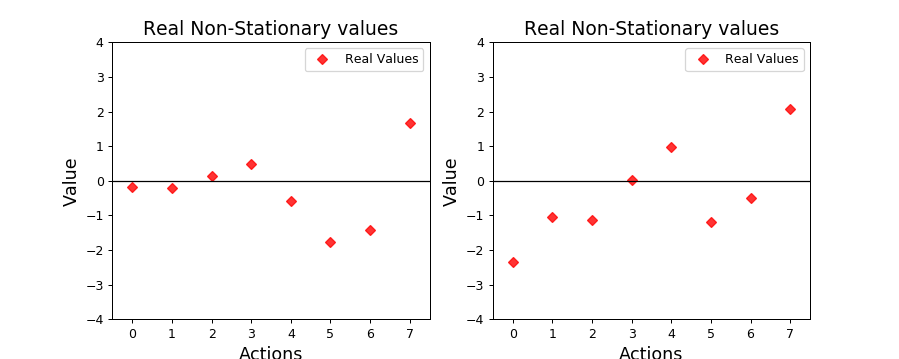

In [3]:
num_experiments = 2
num_bandits = 8
num_steps = 100
action = np.array([0,0]) # Since we're not interested in the agent, use a static action

means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = NonStationaryArmedBanditsEnv(means, stdev)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Real Non-Stationary values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    _, reward, _, _ = env.step(action)
    
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        init_ax(i)
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./non-stationary-env2.gif', writer='imagemagick', fps=60)

## Current Performance

Let's use the previously seen ɛ-greedy Agent and see how it performs against this environment. Animations must be longer to capture the behavior.

### ɛ-greedy Agent

In [4]:
def argmax(q_values):
    """
    Takes in a matrix of n*k q_values and returns the index
    of the item with the highest value for each row. 
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of
    the highest value in q_values for each row.
    """
    # Generate a mask of the max values for each row
    mask = q_values == q_values.max(axis=1)[:, None]
    # Generate noise to be added to the ties
    r_noise = 1e-6*np.random.random(q_values.shape)
    # Get the argmax of the noisy masked values
    return np.argmax(r_noise*mask,axis=1)

In [5]:
class EpsilonGreedyAgent:
    def __init__(self, reward_estimates, epsilon):
        """
        Our agent takes as input the initial reward estimates.
        This estimates will be updated incrementally after each 
        interaction with the environment.
        """
        assert len(reward_estimates.shape) == 2
        assert epsilon >= 0 and epsilon <= 1
        
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)
        self.epsilon = epsilon
        
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action
    
    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Update the reward difference incementally
        self.reward_estimates[np.arange(self.num_experiments), action] += (1/n)*error

Plotting the agent behavior. Here, the red dots are the real values from the environment. The orange dot is the best current action to take. The blue bars are the estimated values from the agent, and the dark blue bar is the best estimated action from experience.

<IPython.core.display.Javascript object>


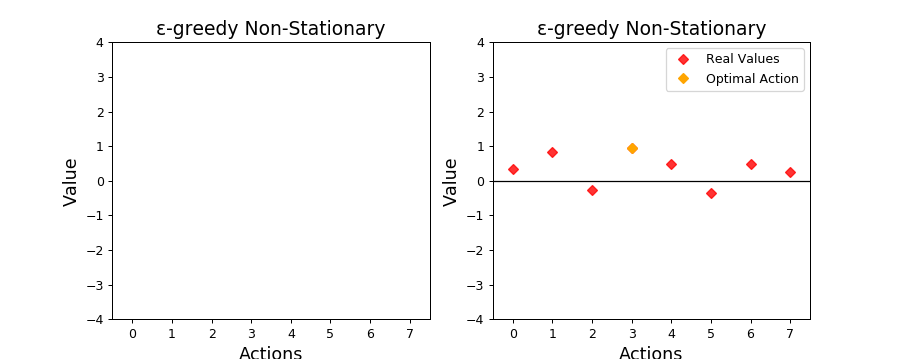

In [6]:
num_experiments = 2
num_bandits = 8
num_steps = 800

means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = NonStationaryArmedBanditsEnv(means, stdev, 0.025)

# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 0.1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='ɛ-greedy Non-Stationary', fontsize=15)
    real_vals = ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    max_real = np.argmax(env.mean[i])
    ax.plot(max_real, env.mean[i][max_real], marker='D', linestyle='', alpha=1, color='orange', label='Optimal Action')
    ax.axhline(0, color='black', lw=1)
    
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        max_exp = np.argmax(estimates)
        ax.bar(max_exp, estimates[max_exp], align='center', color='blue', alpha=0.6, label='Estimated Optimal Action')
        ax.text(5.5, -3.8, "Step: "+str(g), fontsize=10)
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./non-stationary-epsilon-max.gif', writer='imagemagick', fps=40)

You may want to run the previous block multiple times to inspect different behaviors. Hopefully it should be noticeable that after many steps, the agent reacts slowly to big changes. If we ran the simulation for a really long time, the agent's estimates would end up converging to some arbitrary values, while the real values would still vary. Let's see the general behavior by plotting an averaged optimality score from 5000 experiments

In [7]:
# Constants for plotting the experiments. Will be used later on.
# Feel free to change them and see how the agent(s) behave
# under different conditions.
num_experiments = 5000
num_steps = 10000
num_actions = 10
epsilon = 0.1
nonstationarity = 0.025

100%|██████████| 10000/10000 [00:54<00:00, 183.20it/s]


<IPython.core.display.Javascript object>


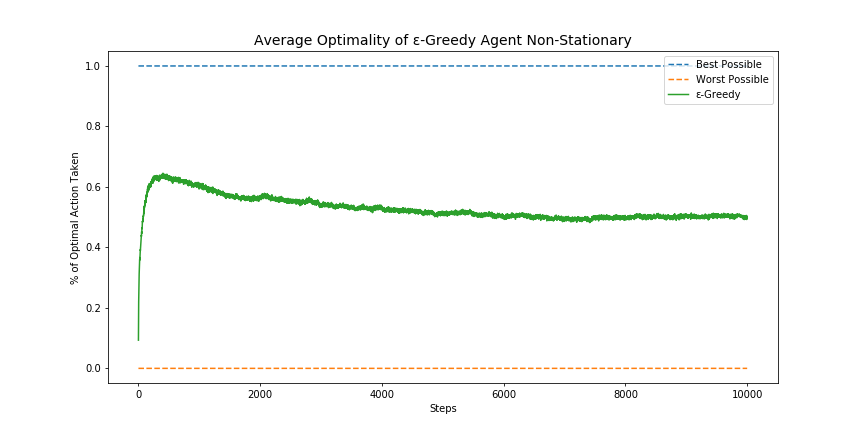

In [8]:
# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions, nonstationarity)
# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    # Get optimal actions from the environment
    optimal = np.argmax(env.mean, axis=1)
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality
    
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "ɛ-Greedy"], loc=1)
plt.title("Average Optimality of ɛ-Greedy Agent Non-Stationary", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
e_greedy_scores = averages
e_greedy_optimality = optimality

As can be seen on the graph above, the epsilon-greedy agent is not a good fit for a dynamic environment. This is because the way it updates its estimates has been designed to automatically converge after a long sequence of steps. If we want our agent to behave better on non-static scenarios, we need to remove such limitation.

## The General Update Rule

The update rule we defined for the epsilon-greedy agent was based on the averaging operation. This was because we're attempting to calculated an estimated expected value, and averaging is a good procedure to obtain such result from experience. We can generalize this formulation to allow for other ways of updating our estimates.

The next equation is the definition of the Incremental Average Update Rule. This is the way we're currently updating our values

<img src='assets/inc-update-rule.png'></img>
          
This is similar to the Gradient Descent update rule, which is used as a standard in other Machine Learning paradigms. Here is a simplified version of this equation.

<img src='assets/simp-gradient-descent.png'></img>

Although the equation above was simplified, and some details have been ommited, the essence is the same. Notice how similar it is to the Update Rule we're using. In Gradient Descent, we use the value $\alpha$ to denote a step-size or learning paramter. This parameter determines how much we update the desired value.

In the case of Incremental Average Update Rule, the step-size is defined as $\dfrac{1}{n}$, which tends to 0 as n gets larger. This explains why after a long sequence of experience, the agent becomes slow and doesn't react to changes in the environment. We could then, express our rule in a more general fashion, by defining our step-size as a parameter of the function.

<img src='assets/gen-update-rule.png'></img>

This allows us to define what step-size we desire to use. One of the standard learning rates in Machine Learning is a small constant scalar. We could therefore try this new implementation, called the Constant step-size Epsilon Greedy Agent.

In [9]:
class CssEpsilonGreedyAgent(EpsilonGreedyAgent):
    """
    Constant Step Size Epsilon Greedy Agent:
    implementation of the epsilon-greedy agent that uses a
    constant step size parameter.
    By default, the step size is set to 0.1.
    Can be changed by supplying a function in the ss_func param.
    The function must receive a parameter n representing the
    number of times the taken action has been selected.
    """
    def __init__(self, reward_estimates, epsilon, ss_func=lambda n: 0.1):
        EpsilonGreedyAgent.__init__(self, reward_estimates, epsilon)
        self.ss_func = ss_func


    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Compute the step size value by running the provided function
        ss = self.ss_func(n)
        
        # Update the reward difference incementally
        self.reward_estimates[np.arange(self.num_experiments), action] += ss*error

Just as in other Machine Learning frameworks, $\alpha$ now defines how much we should update our estimates after every interaction. By using a small constant number, we allow our agent to always adapt and change from experience. Let's see how the agent behaves now on a non-stationary environment, compared to the epsilon-greedy strategy.

100%|██████████| 10000/10000 [00:53<00:00, 186.63it/s]


<IPython.core.display.Javascript object>


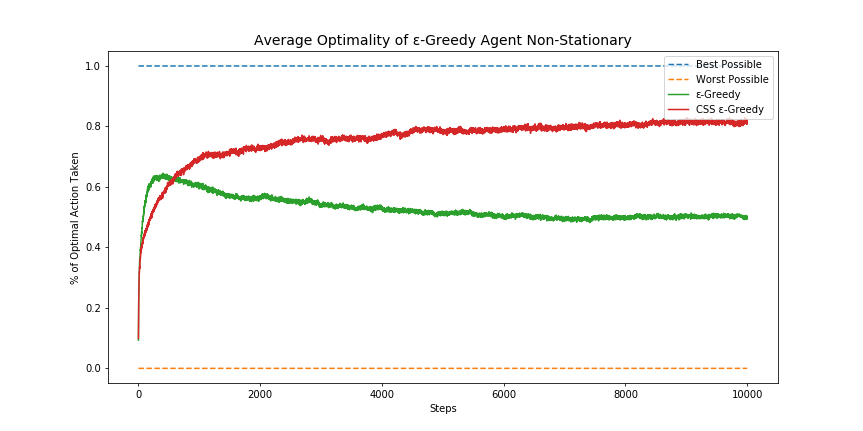

In [10]:
# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions, nonstationarity)
# Initialize the agent
agent = CssEpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    # Get optimal actions from the environment
    optimal = np.argmax(env.mean, axis=1)
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality
    
css_e_greedy_scores = averages
css_e_greedy_optimality = optimality

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(e_greedy_optimality)
plt.plot(css_e_greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "ɛ-Greedy", "CSS ɛ-Greedy"], loc=1)
plt.title("Average Optimality of ɛ-Greedy Agent Non-Stationary", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()


By using a constant step-size, our agent was capable of adapting to changes in the environment. The effect of using a constant value for our learning parameter is that all experience are weighted the same, and that past experience can be overriden given enough knowledge from recent interactions.

## Comparing step-size values

Now that we have added a new parameter, it's important to understand how it works and values it can (and should or shouldn't take.

The step-size parameter can be considered to be a measure of confidence on how representative the most recent interaction is to the overall task. A step-size of 1 indicates total confidence, while 0 represents none. Let's observe how the update rule behaves in both scenarios

If the step-size is 1, we're indicating total confidence that our previous interaction represents the totality of the problem. This is what happens to the update rule

<img src='assets/css-1-update-rule.png'></img>


In this case, we're saying that the estimated value should equal the received reward, disregarding previous experience.

If the step-size is 0, we're indicating a total distrust on how representative the previous experience is of the task at hand. This is how the update rule looks in that case

<img src='assets/css-0-update-rule.png'></img>

In such situation, we're saying that we don't want to update the estimated values.

For any other value between 0 and 1, we're affecting how quickly our agent converges and adapts to changes. Really high values makes the agent faster to converge but noisier, while lower values makes it slower to converge and adapt, but more robust to noisy rewards. Let's see how they compare to the current task

In [11]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1, nonstationarity=0.1, ss=lambda n: 0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions, nonstationarity)
    # Initialize the agent
    agent = CssEpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon, ss)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
     
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        optimal = np.argmax(env.mean, axis=1)
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

<IPython.core.display.Javascript object>


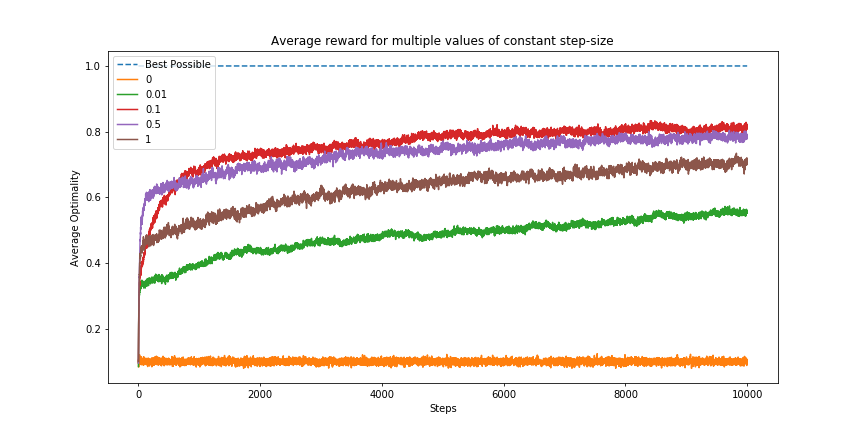

100%|██████████| 10000/10000 [00:27<00:00, 358.93it/s]


In [12]:
num_experiments = 2500
num_steps = 10000
num_actions = 10
ss_funcs = np.array([lambda n: 0, lambda n: 0.01, lambda n: 0.1, lambda n: 0.5, lambda n: 1])
ss_vals = [0, 0.01, 0.1, 0.5, 1]

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--')


for ss_func in ss_funcs:
    optimality, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon, nonstationarity, ss_func)
    
    plt.plot(optimality)
    
plt.legend(["Best Possible"] + ss_vals)
plt.title("Average reward for multiple values of constant step-size")
plt.xlabel("Steps")
plt.ylabel("Average Optimality")
plt.show()

As predicted, the extremes are not well suited for the problem, low values converge slower and higher values converge faster. Different to other fields of Machine Learning, in which the learning-rate or step-size affects mostly convergence time and accuracy towards optimality, in Reinforcement Learning the step-size is tightly linked to how dynamic the environment is. A really dynamic world (one that changes often and rapidly) would require high values for our step size, or else our agent will simply not be fast enough to keep up with the variability of the world.